In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *
from sensetools.plots import feature_labeller

In [12]:
from scipy.stats import spearmanr
from collections import defaultdict

In [8]:
protein = '1fme'

In [9]:
summary_path = f'{protein}/summary.h5'
vamps = pd.read_hdf(summary_path, key='vamps')
vamps.reset_index(inplace=True)

In [10]:
vamps['rank'] = vamps.groupby(['lag', 'process'])['median'].rank(ascending=False)

In [11]:
vamps.head()

,hp_ix,lag,process,median,lb,ub,count,rank
0,28,1,2,1.977601,1.970773,1.991624,100,122.0
1,28,1,3,2.950773,2.927300,2.975330,100,115.0
2,28,1,4,3.915235,3.871567,3.950134,100,106.0
3,28,1,5,4.873431,4.811114,4.915432,100,100.0
4,28,1,6,5.817250,5.713481,5.877248,100,98.0


In [13]:
def spearmans(df: pd.DataFrame, proc: int, top: int = 95) -> pd.DataFrame: 
    lags = df.lag.unique()
    n_lags = len(lags)
    results = defaultdict(list)

    for i in range(n_lags):
        i_lag = lags[i]
        keep_ix = df.loc[(df['rank'] <= top) & (df.lag == i_lag) & (df.process == proc), 'hp_ix'].values
        ps = []
        for j in range(n_lags): 
            i_lag, j_lag = lags[i], lags[j]
            a = df.loc[(df.lag == i_lag) & (df.process == proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
            b = df.loc[(df.lag == j_lag) & (df.process == proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
#             print(len(a), len(b))
            r, p = spearmanr(a, b)
            ps.append(p)
            results['i_lag'].append(i_lag)
            results['j_lag'].append(j_lag)
            results['r'].append(r)
#         print(np.mean(p)>0.05)
    df = pd.DataFrame(results)
    df = df.pivot_table(values='r', index='i_lag', columns='j_lag')
    return df

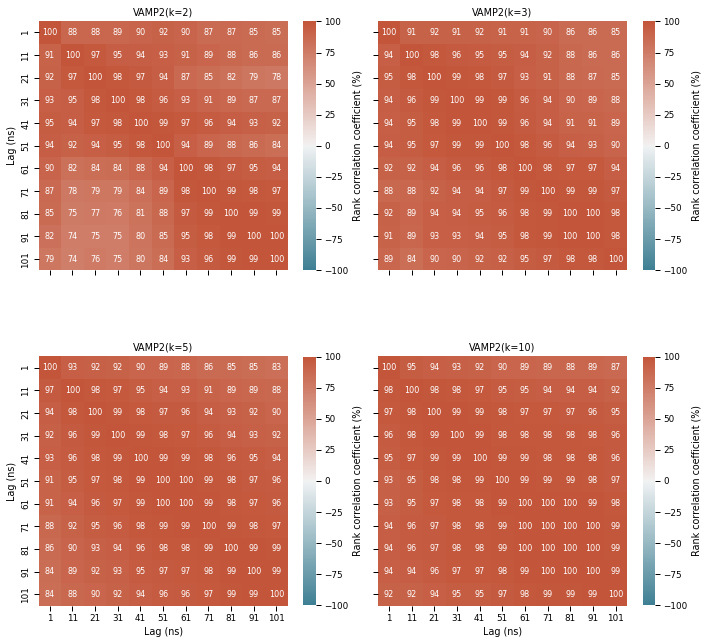

In [22]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    
    procs = [2, 3, 5, 10]
    for i in range(2):
        for j in range(2):
            ax = axes[i, j]
            proc = np.reshape(procs, axes.shape)[i, j]
            df = spearmans(vamps, proc, 30)
            

            sns.heatmap(df*100, ax=ax, vmin=-100, vmax=100, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=True, 
                        annot_kws=dict(size='small'), square=True, fmt='2.0f', 
                        cbar_kws=dict(shrink=0.7, label='Rank correlation coefficient (%)'))
            if i == 1:
                ax.set_xlabel('Lag (ns)')
            else: 
                ax.set_xlabel('')
            if j == 0: 
                ax.set_ylabel('Lag (ns)')
            else: 
                ax.set_ylabel('')
            ax.set_title(f'VAMP2(k={proc})')
                
    plt.tight_layout()
    plt.savefig(f'{protein}/{protein}_vamp_rank_vs_lag.pdf', bbox_inches='tight')